# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

annotations_file:  data/annotations/image_info_test2014.json
vocab_from_file:  True
Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

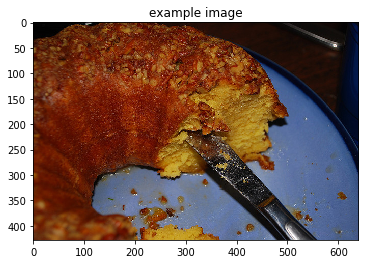

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torch.nn.functional as F

# ATTENTION
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        #resnet = models.resnet50(pretrained=True)
        resnet = models.resnet101(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    
# ATTENTION
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention.
    Reference:
    https://blog.floydhub.com/attention-mechanism/#bahdanau-att-step1 --> Attention Mechanism
    https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning --> PyTorch Image Captioning
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights
        """
        #print('encoder_out.shape: ', encoder_out.shape)
        #print('decoder_hidden.shape: ', decoder_hidden.shape)
        #print('encoder_out: ', encoder_out)
        #print('decoder_hidden: ', decoder_hidden)
        att1 = self.encoder_att(encoder_out)  # (batch_size, attention_dim)
        #print('encoder_out: ', encoder_out.shape)
        #print('att1 -> (batch_size, attention_dim): ', att1.shape)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        #print('decoder_hidden: ', decoder_hidden.shape)
        #print('att2 -> (batch_size, attention_dim): ', att2.shape)
        #att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        att = self.full_att(self.tanh(att1 + att2))  # (batch_size, num_pixels)
        #print('att -> (batch_size, num_pixels): ', att.shape)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        #print('alpha -> (batch_size, num_pixels): ', alpha.shape)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        #print('attention_weighted_encoding -> (batch_size, encoder_dim): ', attention_weighted_encoding.shape)

        return attention_weighted_encoding, alpha

    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, decoder_size, vocab_size, attention_size=512, encoder_size=512, dropout=0.25):
        '''
        [See the diagram of the decoder in Notebook 1]
        The RNN needs to have 4 basic components :
            1. Word Embedding layer : maps the captions to embedded word vector of embed_size.
            2. LSTM layer : inputs( embedded feature vector from CNN , embedded word vector ).
            3. Hidden layer : Takes LSTM output as input and maps it 
                          to (batch_size, caption length, decoder_size) tensor.
            4. Linear layer : Maps the hidden layer output to the number of words
                          we want as output, vocab_size.
        '''
        
        super(DecoderRNN, self).__init__()
        self.encoder_size = encoder_size
        self.attention_size = attention_size
        self.embed_size = embed_size
        self.decoder_size = decoder_size
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        '''
        Embedding layer parameters:
            vocab_size : size of the dictionary of embeddings, 
                basically the number of tokens in the vocabulary(word2idx) for that batch of data.
            embed_size : the size of each embedding vector of captions
        '''
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)

        '''
        BahdanauAttention layer parameters:
        '''
        self.attention_layer = BahdanauAttention(encoder_size, decoder_size, attention_size)  # attention network
        
        '''
        LSTM layer parameters :
            input_size  = embed_size 
            hidden_size = decoder_size     # number of units in hidden layer of LSTM  
            num_layers  = 1               # number of LSTM layers ( = 1, by default )
            batch_first = True            # input , output need to have batch size as 1st dimension
            dropout     = 0               # did not use dropout 
        
        Other parameters were not changed from default values provided in the PyTorch implementation.
        '''
        #print('embed_size: ', embed_size)
        #print('encoder_size: ', encoder_size)
        #print('decoder_size: ', decoder_size)
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html
        self.lstm_layer = nn.LSTMCell( input_size = embed_size+encoder_size, 
                             hidden_size = decoder_size, 
                             bias=True)
                             #num_layers = num_layers, 
                             #dropout = dropout, 
                             #batch_first=True )
        
        self.f_beta = nn.Linear(decoder_size, encoder_size)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()

        self.init_h_layer = nn.Linear(encoder_size, decoder_size)  # linear layer to find initial hidden state of LSTMCell
        self.init_c_layer = nn.Linear(encoder_size, decoder_size)  # linear layer to find initial cell state of LSTMCell
        self.linear_fc_layer = nn.Linear(decoder_size, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding_layer.weight.data.uniform_(-0.1, 0.1)
        self.linear_fc_layer.bias.data.fill_(0)
        self.linear_fc_layer.weight.data.uniform_(-0.1, 0.1)


    def init_decoder_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, encoder_dim)
        :return: hidden state, cell state
        """
        #print('encoder_out: ', encoder_out)
        #print('encoder_out.shape: ', encoder_out.shape)
        #mean_encoder_out = encoder_out.mean(dim=0) # TODO: DA SISTEMARE
        #print('mean_encoder_out: ', mean_encoder_out)
        #print('mean_encoder_out.shape: ', mean_encoder_out.shape)
        #h = self.init_h_layer(mean_encoder_out)  # (batch_size, decoder_dim)
        #c = self.init_c_layer(mean_encoder_out)
        h = self.init_h_layer(encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c_layer(encoder_out)
        return h, c

    
    def forward(self, encoder_out, captions):
        '''
        Arguments :
        For a forward pass, the instantiation of the RNNDecoder class
        receives as inputs 2 arguments  :
        -> encoder_out : ouput of CNNEncoder having shape (batch_size, embed_size).
        -> captions : a PyTorch tensor corresponding to the last batch of captions 
                      having shape (batch_size, caption_length) .
        NOTE : Input parameters have first dimension as batch_size.
        '''
        
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        #print ('batch_size: ', batch_size)
        #print ('encoder_out.shape: ', encoder_out.shape)
        #print ('encoder_dim: ', encoder_dim)
        #print ('vocab_size: ', vocab_size)
        #print ('captions.shape: ', captions.shape)

        # Flatten image
        #encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        #num_pixels = encoder_out.size(1)
        #print('num_pixels: ', num_pixels)
        #print('encoder_out -> (batch_size, encoder_dim): ', encoder_out.shape)
        
        # Discard the <end> word to avoid the following error in Notebook 1 : Step 4
        # (outputs.shape[1]==captions.shape[1]) condition won't be satisfied otherwise.
        # AssertionError: The shape of the decoder output is incorrect.
        # captions.shape: torch.Size([10, 16])
        #captions = captions[:, :-1] 
        captions_length = captions.shape[1]
        captions_length_list = [captions_length for i in range(captions.shape[0])]
        caption_lengths, sort_ind = torch.FloatTensor(captions_length_list).sort(dim=0, descending=True)
        caption_lengths = (caption_lengths).tolist()
        #print('caption_lengths: ',caption_lengths)
        
        # Pass image captions through the word_embeddings layer.
        # output shape : (batch_size, caption length , embed_size)
        embeddings = self.embedding_layer(captions) # (batch_size, max_caption_length, embed_dim)
        #print ('embeddings -> (batch_size, max_caption_length, embed_dim): ', embeddings.shape)

        # Initialize LSTM state
        #h, c = self.init_decoder_state(encoder_out)  # (batch_size, decoder_dim)
        h, c = self.init_decoder_state(encoder_out)  # (batch_size, decoder_dim)
        #print('h.shape -> (batch_size, decoder_dim): ',h.shape)
        #print('c.shape -> (batch_size, decoder_dim): ',c.shape)

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, int(max(caption_lengths)), vocab_size).to(device)
        alphas = torch.zeros(batch_size, int(max(caption_lengths))).to(device)
        #print('predictions.shape: ', predictions.shape)
        #print('alphas.shape: ', alphas.shape)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(int(max(caption_lengths))):
            batch_size_t = sum([l > t for l in caption_lengths])
            #print('Ciclo For nro: ', t)
            #print('batch_size_t: ', batch_size_t)
            attention_weighted_encoding, alpha = self.attention_layer(encoder_out, h)

            #gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            #attention_weighted_encoding = gate * attention_weighted_encoding

            #print('attention_weighted_encoding.shape: ', attention_weighted_encoding.shape)
            #print('alpha.shape: ', alpha.shape)
            #print('embeddings[:, t, :].shape: ', embeddings[:, t, :].shape)
            #print('embeddings.shape: ', embeddings.shape)
            #print('h.shape: ', h.shape)
            #print('c.shape: ', c.shape)
            #print('embeddings[:, t, :] + attention_weighted_encoding: ', torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1).shape)
            #print('embeddings + attention_weighted_encoding: ', torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1).shape)
            
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # TODO: problema con c, viene creato come torch.Size([10, 512]) e poi diventa tupla dopo questa chiamata 
            #x, (h, c) = self.lstm_layer(torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1).unsqueeze(1), (h.unsqueeze(0), c.unsqueeze(0)))  # (batch_size_t, decoder_dim)
            h, c = self.lstm_layer(torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1), (h, c))  # (batch_size_t, decoder_dim)
            #print('x.shape: ', x.shape)
            #print('h.shape: ', h.shape)
            #print('c.shape: ', c.shape)
            h = h.squeeze()
            c = c.squeeze()
            #print('h.shape: ', h.shape)
            #print('c.shape: ', c.shape)
            #print('c: ', c)

            preds = self.linear_fc_layer(h)  # (batch_size_t, vocab_size)
            #print('preds.shape: ', preds.shape)
            #print('alpha.shape: ', alpha.shape)
            #preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            #predictions[:batch_size_t, t, :] = preds
            #alphas[:batch_size_t, t, :] = alpha
            predictions[:, t, :] = preds
            alphas[:, t] = alpha.squeeze()
            #print('predictions.shape: ', predictions.shape)
            #print('alphas.shape: ', alphas.shape)
        
        return predictions #, captions, captions_length_list, alphas

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        pass


    def beam_search_predictions(self, encoder_out, decoder, device, vocab, beam_index = 3, max_len=20):
        word_start = vocab.start_word
        word_end = vocab.end_word
        start = vocab(word_start)
        end = vocab(word_end)
        #print('start: ', start)
        #print('end: ', end)
        vocab_size = len(vocab)

        # We'll treat the problem as having a batch size of beam_index
        #print('encoder_out.shape: ', encoder_out.shape)
        enc_image_size = encoder_out.size(1)
        #print('enc_image_size: ', enc_image_size)
        encoder_dim = encoder_out.size(2)
        #print('encoder_dim: ', encoder_dim)
        encoder_out_new = encoder_out.expand(beam_index, 1, encoder_dim)  # (beam_index, encoder_dim)
        print('encoder_out.shape: ', encoder_out.shape)

        # Tensor to store top beam_index sequences' scores; now they're just 0
        top_beam_index_scores = torch.zeros(beam_index, 1).to(device)  # (beam_index, 1)

        # Tensor to store top beam_index previous words at each step; now they're just <start>
        beam_index_prev_words = torch.LongTensor([[start]] * beam_index).to(device)  # (beam_index, 1)
        print('beam_index_prev_words.shape: ', beam_index_prev_words.shape)
        
        # Tensor to store top k sequences; now they're just <start>
        seqs = beam_index_prev_words  # (beam_index, 1)
        # Tensor to store top k sequences' alphas; now they're just 1s
        #seqs_alpha = torch.ones(beam_index, 1, enc_image_size, enc_image_size).to(device)  # (beam_index, 1, enc_image_size, enc_image_size)

        # Lists to store completed sequences, their alphas and scores
        complete_seqs = list()
        #complete_seqs_alpha = list()
        complete_seqs_scores = list()
    
        # Start decoding
        step = 1
        ## Inizialize the Hodden and Cell State
        h, c = decoder.init_decoder_state(encoder_out_new)
        h = h.squeeze()
        c = c.squeeze()

        while True:
            print('step: ', step)
            print('encoder_out_new.shape: ', encoder_out_new.shape)
            print('h.shape: ', h.shape)
            print('encoder_out_new min: ', encoder_out_new.min())
            print('encoder_out_new max: ', encoder_out_new.max())
            print('h min: ', h.min())
            print('h max: ', h.max())
            embeddings = decoder.embedding_layer(beam_index_prev_words).squeeze(1) # (beam_index, embed_dim)
            attention_weighted_encoding, alpha = decoder.attention_layer(encoder_out_new, h) # (beam_index, encoder_dim)
            alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (beam_index, enc_image_size, enc_image_size)
            
            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            #print('gate.shape: ', gate.shape)
            #print('attention_weighted_encoding.shape: ', attention_weighted_encoding.shape)
            attention_weighted_encoding = gate * attention_weighted_encoding.squeeze(1)
            
            #print('embeddings.shape: ', embeddings.shape)
            #print('attention_weighted_encoding.shape: ', attention_weighted_encoding.shape)
            #print('embeddings + attention_weighted_encoding: ', torch.cat([embeddings, attention_weighted_encoding], dim=1).shape)
            #print('h.shape: ', h.shape)
            #print('c.shape: ', c.shape)
            h, c = decoder.lstm_layer(torch.cat([embeddings, attention_weighted_encoding.squeeze(1)], dim=1), (h, c))  # (beam_index, decoder_dim)
            preds = decoder.linear_fc_layer(h)
            
            preds = F.log_softmax(preds, dim=1)

            scores = top_beam_index_scores.expand_as(preds) + preds  # (beam_index, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_beam_index_scores, top_beam_index_words = torch.topk(scores[0], beam_index, 0, True, True)  # (beam_index)
                prev_word_inds = top_beam_index_words / vocab_size  # (beam_index)
                next_word_inds = top_beam_index_words % vocab_size  # (beam_index)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_beam_index_scores, top_beam_index_words = torch.topk(scores.view(-1), beam_index, 0, True, True)  # (beam_index)
                prev_word_inds = next_word_inds #top_beam_index_words / vocab_size  # (beam_index)
                next_word_inds = top_beam_index_words % vocab_size  # (beam_index)

            # Convert unrolled indices to actual indices of scores
            #prev_word_inds = next_word_inds #top_beam_index_words / vocab_size  # (beam_index)
            #next_word_inds = top_beam_index_words % vocab_size  # (beam_index)
            #print('top_beam_index_words: ', top_beam_index_words)
            #print('prev_word_inds: ', prev_word_inds)
            #print('next_word_inds: ', next_word_inds)
            
            # Which sequences are incomplete (didn't reach <end>)?
            '''print('end: ', end)
            gen = (count for count,ele in enumerate(next_word_inds) if ele != end)
            for count in gen:
                print('count: ', count)
            gen = (ele for count,ele in enumerate(next_word_inds) if ele != end)
            for ele in gen:
                print('ele: ', ele)'''
            #print('enumerate(next_word_inds): ', list(enumerate(next_word_inds)))
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != end]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))
            #print('incomplete_inds: ', incomplete_inds)
            #print('complete_inds: ', complete_inds)

            # Add new words to sequences, alphas
            #print('prev_word_inds: ', prev_word_inds)
            #print('next_word_inds: ', next_word_inds)
            #print('seqs.shape: ', seqs.shape)
            #print('seqs: ', seqs)
            #print('seqs[prev_word_inds].shape: ', seqs[prev_word_inds].shape)
            #print('next_word_inds.unsqueeze(1).shape: ', next_word_inds.unsqueeze(1).shape)
            #seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (beam_index, step+1)
            seqs = torch.cat([seqs, next_word_inds.unsqueeze(1)], dim=1)  # (beam_index, step+1)
            print('seqs.shape: ', seqs.shape)
            print('seqs: ', seqs)
            #print('seqs_alpha.shape: ', seqs_alpha.shape)
            #print('alpha[prev_word_inds].unsqueeze(1).shape: ', alpha[prev_word_inds].unsqueeze(1).shape)
            #seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1)  # (beam_index, step+1, enc_image_size, enc_image_size)
            
            #print('seqs_alpha.shape: ', seqs_alpha.shape)
            #print('prev_word_inds: ', prev_word_inds)
            #print('alpha.unsqueeze(1).shape: ', alpha.unsqueeze(1).shape)
            #print('torch.cat([seqs_alpha, alpha.unsqueeze(1)], dim=1).shape: ', torch.cat([seqs_alpha, alpha.unsqueeze(1)], dim=1).shape)
            #seqs_alpha = torch.cat([seqs_alpha, alpha[prev_word_inds].unsqueeze(1)], dim=1)  # (beam_index, step+1, enc_image_size, enc_image_size)

            #print('seqs: ', seqs)
            #seqs = seqs[incomplete_inds]
            #seqs_alpha = seqs_alpha[incomplete_inds]
            #h = h[prev_word_inds[incomplete_inds]]
            #c = c[prev_word_inds[incomplete_inds]]
            #encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_beam_index_scores = top_beam_index_scores.unsqueeze(1)
            beam_index_prev_words = next_word_inds.unsqueeze(1)
            
            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                #complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
                complete_seqs_scores.extend(top_beam_index_scores[complete_inds])
            beam_index -= len(complete_inds)  # reduce beam length accordingly
            
            # Proceed with incomplete sequences
            if beam_index == 0:
                break

            # Break if things have been going on too long
            if step > 50:
                complete_seqs.extend(seqs.tolist())
                #complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
                complete_seqs_scores.extend(top_beam_index_scores)
                break
            step += 1

        print('complete_seqs_scores: ', complete_seqs_scores)
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
        #alphas = complete_seqs_alpha[i]

        return seq #, alphas

In [5]:
# Watch for any changes in model.py, and re-load it automatically.
#% load_ext autoreload
#% autoreload 2

import os
import torch
#from modelAttention import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'models/encoder-2.pkl'
decoder_file = 'models/decoder-2.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file, map_location=device))
decoder.load_state_dict(torch.load(decoder_file, map_location=device))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding_layer): Embedding(9947, 512)
  (attention_layer): BahdanauAttention(
    (encoder_att): Linear(in_features=512, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
    (softmax): Softmax()
  )
  (lstm_layer): LSTMCell(1024, 512)
  (f_beta): Linear(in_features=512, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (init_h_layer): Linear(in_features=512, out_features=512, bias=True)
  (init_c_layer): Linear(in_features=512, out_features=512, bias=True)
  (linear_fc_layer): Linear(in_features=512, out_features=9947, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

vocab = data_loader.dataset.vocab
start_word = vocab.start_word
#print(vocab.start_word)
#print(vocab(start_word))

# Pass the embedded image features through the model to get a predicted caption.
#output = decoder.sample(features) # Vocabulary at data_loader.dataset.vocab
#output, alphas = decoder.beam_search_predictions(features, decoder, device, vocab, beam_index = 3, max_len=20)
output = decoder.beam_search_predictions(features, decoder, device, vocab, beam_index = 3, max_len=20)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-14.1626, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(14.7897, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[ 0,  0],
        [ 0, 20],
        [ 0, 47]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor([[ 0, 

step:  24
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 25])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3],
        [ 0, 20, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3],
        [ 0, 47,  3, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  25
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cud

h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 43])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3],
        [ 0, 20, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3],
        [ 0, 47,  3, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  43
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cuda:0'

seqs.shape:  torch.Size([3, 51])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 20, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 47,  3, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]],
       device='cuda:0')
step:  51
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.0996, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(8.7711, device='cuda:0', grad_fn=<MaxBack

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [7]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ""
    for i in output:
        #print('i: ', i)
        word = data_loader.dataset.vocab.idx2word[i]
        if (word == data_loader.dataset.vocab.start_word):
            continue
        elif (word == data_loader.dataset.vocab.end_word):
            break
        else:
            sentence = sentence + " " + word
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [8]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence:  the a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [9]:
def get_prediction():
    vocab = data_loader.dataset.vocab
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    #output = decoder.sample(features)    
    #output, alphas = decoder.beam_search_predictions(features, decoder, device, vocab, beam_index = 3, max_len=20)
    output = decoder.beam_search_predictions(features, decoder, device, vocab, beam_index = 3, max_len=20)
    #print('output: ', output)
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

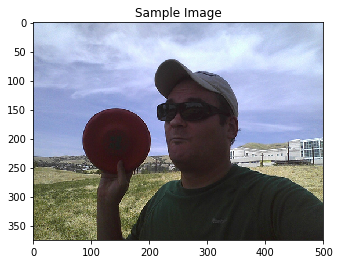

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-14.4736, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(12.6580, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[  0,   0],
        [  0,  51],
        [  0, 454]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor([[

encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 24])
seqs:  tensor([[  0,   0,   0,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0,  51,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0, 454,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3]], device='cuda:0')
step:  24
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h

step:  33
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 34])
seqs:  tensor([[  0,   0,   0,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3],
        [  0,  51,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3],
        [  0, 454,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3]]

step:  42
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3766, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(7.7516, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 43])
seqs:  tensor([[  0,   0,   0,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3],
        [  0,  51,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3],
        [  0, 454,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          

h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 51])
seqs:  tensor([[  0,   0,   0,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0,  51,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0, 454,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,

In [10]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

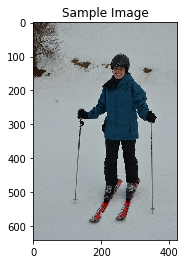

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-11.2038, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-15.9161, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(11.2261, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[ 0,  0],
        [ 0, 51],
        [ 0,  3]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-11.2038, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor([[ 0, 

h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 24])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 51, 32, 50,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  24
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-11.2038, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 25])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,

step:  41
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-11.2038, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 42])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 51, 32, 50,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]], dev

encoder_out_new max:  tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 50])
seqs:  tensor([[ 0,  0,  0, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 51, 32, 50,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]],
       device='cuda:0')
step:  50
encoder_out_new.shape:  torch.Size([3, 1, 

In [11]:
get_prediction()

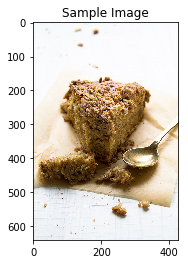

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-12.4555, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(14.1121, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[ 0,  0],
        [ 0, 47],
        [ 0, 51]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor([[ 0, 

h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 24])
seqs:  tensor([[ 0,  0,  0, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 47, 47, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 51,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  24
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 25])
seqs:  tensor([[ 0,  0,  0, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,

step:  34
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 35])
seqs:  tensor([[ 0,  0,  0, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 47, 47, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 51,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]],
       device='cuda:0')
step:  35
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
e

step:  43
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 44])
seqs:  tensor([[ 0,  0,  0, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 47, 47, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 51,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  

step:  51
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-9.2747, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.3845, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 52])
seqs:  tensor([[ 0,  0,  0, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 47, 47, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 51,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3

In [13]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

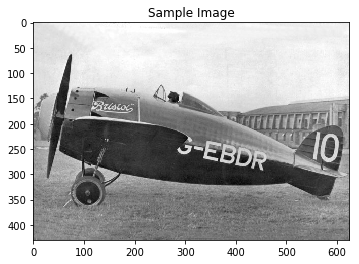

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-16.0324, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(12.7116, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[  0,   0],
        [  0, 628],
        [  0,  39]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor(

seqs:  tensor([[  0,   0,   0,  47,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0, 628,  47,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0,  39,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3]], device='cuda:0')
step:  23
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 24])
seqs:  tensor([[  0,   0,   0,  47,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0, 628,  47,  3

step:  33
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 34])
seqs:  tensor([[  0,   0,   0,  47,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3],
        [  0, 628,  47,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3],
        [  0,  39,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3]

       device='cuda:0')
step:  42
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 43])
seqs:  tensor([[  0,   0,   0,  47,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3],
        [  0, 628,  47,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3],
        [  0,  39,   3,   3,   3,   3,   3,   3,   3,   3,   3, 

step:  50
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-8.3354, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(10.0464, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 51])
seqs:  tensor([[  0,   0,   0,  47,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        [  0, 628,  47,  32,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3],
        

In [14]:
get_prediction()

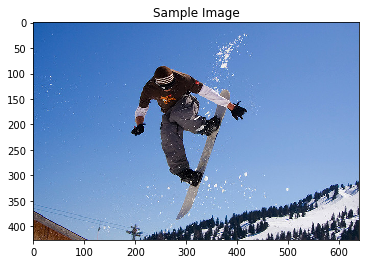

encoder_out.shape:  torch.Size([1, 1, 512])
beam_index_prev_words.shape:  torch.Size([3, 1])
step:  1
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-16.5586, device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(12.5697, device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 2])
seqs:  tensor([[ 0,  0],
        [ 0, 77],
        [ 0, 51]], device='cuda:0')
step:  2
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 3])
seqs:  tensor([[ 0, 

encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 24])
seqs:  tensor([[ 0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 77, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 51,  3, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  24
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  te

seqs.shape:  torch.Size([3, 42])
seqs:  tensor([[ 0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 77, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3],
        [ 0, 51,  3, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3]], device='cuda:0')
step:  42
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<M

step:  50
encoder_out_new.shape:  torch.Size([3, 1, 512])
h.shape:  torch.Size([3, 512])
encoder_out_new min:  tensor(-10.4973, device='cuda:0', grad_fn=<MinBackward1>)
encoder_out_new max:  tensor(9.5410, device='cuda:0', grad_fn=<MaxBackward1>)
h min:  tensor(-1., device='cuda:0', grad_fn=<MinBackward1>)
h max:  tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
seqs.shape:  torch.Size([3, 51])
seqs:  tensor([[ 0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 77, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
        [ 0, 51,  3, 32,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3

In [15]:
get_prediction()